In [105]:
import SimDAT2D.SimDAT2D as sim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import IsoDAT2D.IsoDAT2D as iso
from PIL import Image
import pyFAI, fabio
from pyFAI.gui import jupyter
import pyFAI
import os
import matplotlib.pyplot as plt
from tifffile import imread
from SimDAT2D import masking
import pyFAI.azimuthalIntegrator as AI
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [26]:
def create_mask_for_tiff(tiff_path, width):
    """
    This function creates a mask for the azimuthal integrator from a TIFF file.
    
    Parameters:
        tiff_path (str): Path to the TIFF file
        width (int): The width of the line of interest
    """
    # Import tiff file
    from tifffile import imread
    image = imread(tiff_path)
    
    # Get the center point (assuming square image)
    center = image.shape[0] // 2
    
    # Create the mask
    mask = np.ones_like(image)
    mask[center-width:center+width, center:] = 0
    
    # Display the mask
    plt.figure(figsize=(5, 5))
    plt.imshow(mask, cmap='viridis')
    plt.title("Mask")
    plt.show()
    
    return mask

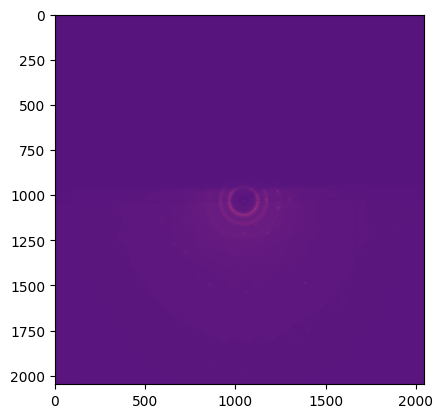

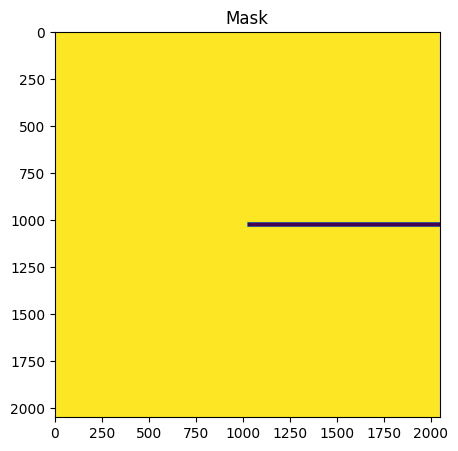

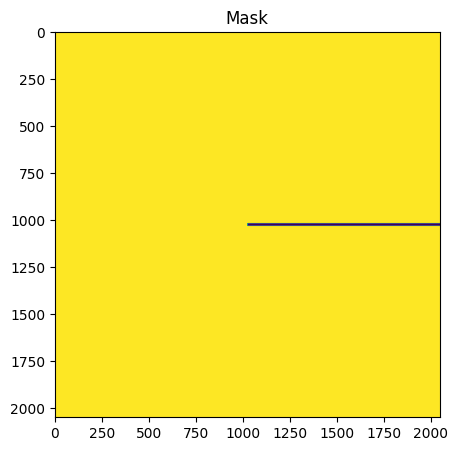

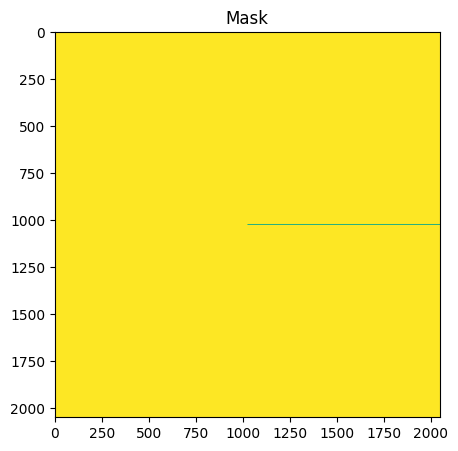

In [27]:
GST_6C_real_0035 = r'C:\Users\kelleymarisa\UFL Dropbox\Marisa Kelley\DNA&MDKShare\copy_data_isodat\p21p1\gits_a_GST_6C_real\gits_a_GST_6C_real_45_mdeg-00035.tif'
GST_6C_real_0035_image = imread(GST_6C_real_0035)
#check image
plt.imshow(GST_6C_real_0035_image, cmap = 'magma')
plt.show()
#create integration mask
mask_12 = create_mask_for_tiff(GST_6C_real_0035, 12)
mask_7 = create_mask_for_tiff(GST_6C_real_0035, 7)
mask_1 = create_mask_for_tiff(GST_6C_real_0035, 1)
#mask_05 = create_mask_for_tiff(GST_6C_real_0035, 0.5)

In [53]:
def apply_polarization(image, distance, center=None, polarization_factor=0.99):
    """
    Apply polarization correction to 2D diffraction image.
    
    Parameters:
        image (2D array): Raw diffraction image
        distance (float): Sample-to-detector distance in meters
        center (tuple): (x,y) beam center coordinates. If None, assumes center of image
        polarization_factor (float): Polarization factor, typically 0.99 for synchrotron
        
    Returns:
        2D array: Polarization-corrected image
    """
    import numpy as np
    
    # Get image dimensions and center if not provided
    ny, nx = image.shape
    if center is None:
        center = (nx//2, ny//2)
    
    # Create coordinate grid relative to beam center
    y, x = np.ogrid[:ny, :nx]
    y = y - center[1]
    x = x - center[0]
    
    # polar coordinates
    r = np.sqrt(x*x + y*y)
    phi = np.arctan2(y, x)
    
    # Calculate 2theta angle for each pixel
    pixel_size = 0.0002  #from poni file
    r_meters = r * pixel_size
    twotheta = np.arctan2(r_meters, distance)
    
    # Calculate polarization correction
    # For synchrotron radiation (horizontal polarization):
    P = (1 - polarization_factor * np.cos(phi)**2 * np.cos(twotheta)**2) / \
        (1 + np.cos(twotheta)**2)
    
    # Apply polarization correction
    corrected = image / P
    
    # Replace any invalid values with NaN
    corrected[~np.isfinite(corrected)] = np.nan
    
    return corrected

In [95]:
polarized_image = apply_polarization(GST_6C_real_0035_image, distance = 0.4179, center=None, polarization_factor=0.1)

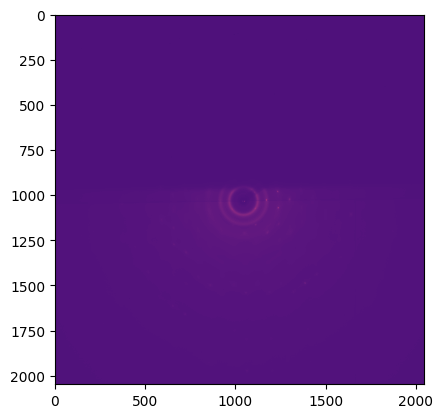

In [96]:
#check image
plt.imshow(polarized_image, cmap = 'magma')
plt.show()

In [56]:
def normalize_image(image, method='mean'):
    """
    Normalize diffraction image using specified method.
    
    Parameters:
        image (2D array): Input diffraction image
        method (str): Normalization method ('mean', 'max', or 'sum')
        
    Returns:
        2D array: Normalized image
    """
    import numpy as np
    
    # Remove zeros and negative values for normalization
    valid_pixels = image[image > 0]
    
    if len(valid_pixels) == 0:
        return image
    
    if method == 'mean':
        norm_factor = np.nanmean(valid_pixels)
    elif method == 'max':
        norm_factor = np.nanmax(valid_pixels)
    elif method == 'sum':
        norm_factor = np.nansum(valid_pixels)
    else:
        raise ValueError("Method must be 'mean', 'max', or 'sum'")
    
    normalized = image / norm_factor
    
    # Replace any invalid values with NaN
    normalized[~np.isfinite(normalized)] = np.nan
    
    return normalized

In [57]:
normalized_image = normalize_image(polarized_image, method='mean')

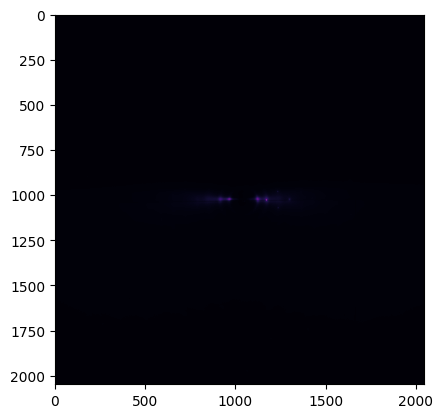

In [58]:
#check image
plt.imshow(normalized_image, cmap = 'magma')
plt.show()

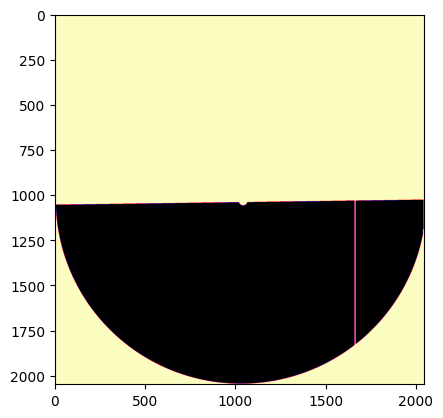

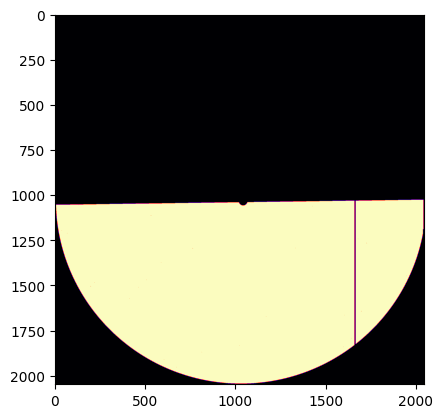

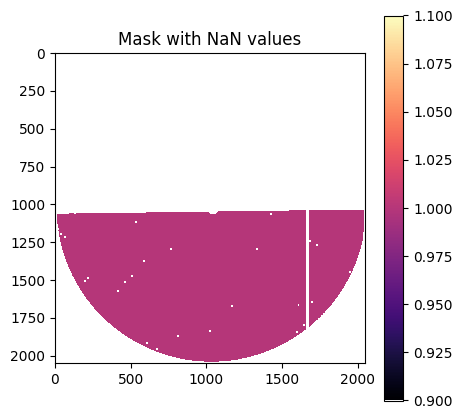

In [34]:
#load image mask
gz_mask_path = r'C:\Users\kelleymarisa\UFL Dropbox\Marisa Kelley\DNA&MDKShare\copy_data_isodat\p21p1\Masks\mask_circle_edge.npy'
gz_mask = np.load(gz_mask_path)
plt.imshow(gz_mask, cmap = 'magma')
plt.show()
# Invert the mask (0s become 1s and 1s become 0s)
gz_inverted_mask = 1 - gz_mask  # or: np.logical_not(mask_12).astype(float)
#check mask
plt.imshow(gz_inverted_mask, cmap = 'magma')
plt.show()

# turned zeros to NaN in invertedpyfai mask
# Convert zeros to NaN
gz_mask_with_nan = gz_inverted_mask.astype(float)  # Convert to float type first since NaN requires float
gz_mask_with_nan[gz_inverted_mask == 0] = np.nan
# Visualize to verify
plt.figure(figsize=(5, 5))
plt.imshow(gz_mask_with_nan, cmap='magma')
plt.title('Mask with NaN values')
plt.colorbar()
plt.show()


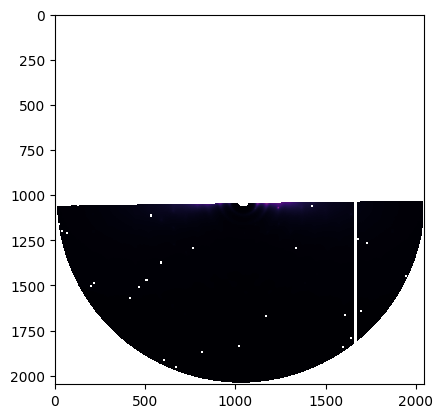

In [100]:
gz_combined_image = normalized_image + gz_mask_with_nan
plt.imshow(gz_combined_image, cmap = 'magma')
plt.show()

In [101]:
def fill_nan_with_neighbor_mean_circle(image, radius=None, center=None):
    """
    Fill NaN values with the mean of neighboring non-NaN pixels, but only within
    a circular region defined by radius and center
    
    Parameters:
    image: 2D numpy array
    radius: radius of circle (default: min(height,width)/2)
    center: (y,x) coordinates of circle center (default: image center)
    """
    # Create a copy of the image
    filled_image = np.copy(image)
    
    # Set defaults if not provided
    if center is None:
        center = (image.shape[0]//2, image.shape[1]//2)  # (y, x)
    if radius is None:
        radius = min(image.shape[0], image.shape[1])//2
        
    # Create a circular mask
    y, x = np.ogrid[:image.shape[0], :image.shape[1]]
    dist_from_center = np.sqrt((y - center[0])**2 + (x - center[1])**2)
    circle_mask = dist_from_center <= radius
    
    # Find NaN pixels
    nan_y, nan_x = np.where(np.isnan(filled_image))
    
    # Loop through each NaN pixel
    for y, x in zip(nan_y, nan_x):
        # Check if this pixel is within the circle
        if circle_mask[y, x]:
            # Define a window around the NaN pixel (5x5 window)
            y_start = max(0, y - 2)
            y_end = min(image.shape[0], y + 3)
            x_start = max(0, x - 2)
            x_end = min(image.shape[1], x + 3)
            
            # Extract the window
            window = filled_image[y_start:y_end, x_start:x_end]
            
            # Calculate mean of non-NaN values in the window
            mean_value = np.nanmean(window)
            
            # Replace NaN with the calculated mean
            filled_image[y, x] = mean_value
            
    # Set all pixels outside circle to NaN
    filled_image[~circle_mask] = np.nan
    
    return filled_image


C:\Users\kelleymarisa\AppData\Local\Temp\ipykernel_26140\2325762507.py:42: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(window)


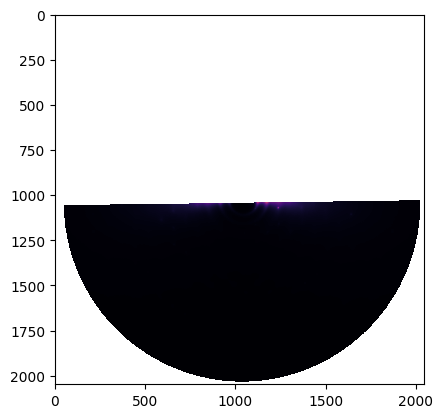

In [103]:
#tiff image = 2048x2048 pixels
gz_filled_with_mean = fill_nan_with_neighbor_mean_circle(gz_combined_image, radius = 992, center = (1048, 1035))
plt.imshow(gz_filled_with_mean, cmap = 'magma')
plt.show()

In [107]:
#Create a function that takes the combined image and integrates it using the azimuthal integrator and displays the 1D image
def integrate_image(combined_image, distance, wavelength, resolution = 3000, mask = None, show = False, radial_range = (0,15)):
    """
    This function integrates the combined image using the azimuthal integrator and displays the 1D image.
    
    Parameters:
        combined_image (2D array): The image of the combined spots and calibration.
    """
    #initialize the azimuthal integrator
    
     # Initialize the detector
    dete = pyFAI.detectors.Perkin()
    p1, p2, p3 = dete.calc_cartesian_positions()
    poni1 = p1.mean()
    poni2 = p2.mean()
    
    
    ai = AI.AzimuthalIntegrator(dist=distance, poni1=poni1, poni2=poni2, detector=dete, wavelength=wavelength)
    
    #integrate the combined image using the azimuthal integrator
    q, I = ai.integrate1d(combined_image, resolution, radial_range = radial_range, unit = 'q_A^-1', mask = mask)
    
    if show == True:
        #plot the 1D image
        plt.figure(figsize=(10, 10))
        plt.plot(q, I)
        plt.title("1D X-Ray Diffraction Image")
        plt.show()
    
    return q, I

In [108]:
def rotate_and_integrate(combined_image, angle_of_rotation, distance, wavelength, resolution = 3000, mask = None):
    """
    This function takes the combined image, the mask, the distance, the wavelength, and the resolution of integration, and rotates the combined image by a user specified angle amount, if the angle specified is 1, the result will be 360 integrations of the combined image, each integration will be rotated by 1 degree.
    
    Parameters:
        combined_image (2D array): The image of the combined spots and calibration.
        angle_of_rotation (int): The angle of rotation.
        distance (float): The distance from the detector to the sample.
        wavelength (float): The wavelength of the x-rays.
        resolution (int): The resolution of the integration.
        mask (2D array): The mask to use for the integration.
    """
    
    import pandas as pd 
    
    #create a dataframe to store the 1D integrations
    df = pd.DataFrame()
    
    # Calculate number of steps for 180 degrees
    n_steps = int(180 / angle_of_rotation)
    angles = np.linspace(0, 180, n_steps, endpoint=False)

    # Pre-allocate lists to store data
    intensity_data = []
    angle_labels = []
    
    # Create a loop that rotates the combined image
    for angle in angles:
        # Rotate the image
        rotated_image = sim.image_rotation(combined_image, angle)
        
        # Integrate the rotated image
        q, I = integrate_image(rotated_image, distance, wavelength, resolution, mask, show=False)
        
        # Add the 1D integration to the dataframe
        # Store data
        intensity_data.append(I)
        angle_labels.append(f"{angle:.3f}")
    
    # Create DataFrame all at once
    df = pd.DataFrame(np.array(intensity_data).T, columns=angle_labels)
        
    #create a waterfall plot of the 1D integrations, where each dataset is moved up on the y axis by a multiple of .5
    plt.figure(figsize=(10, 10))
    
    # Plot using angles array instead of range()
    for angle in angles[1:len(angles)-1]:  # Skip first & last angles
        plt.plot(q, (df[f"{angle:.3f}"] + angle*.01), alpha=.55, c='black')
    plt.xlabel('q A $^(-1)$')
    plt.ylabel('Intensity')
    plt.title("Waterfall Plot of Rotated 1D X-Ray Diffraction Images")
    plt.show()        
    return q, df

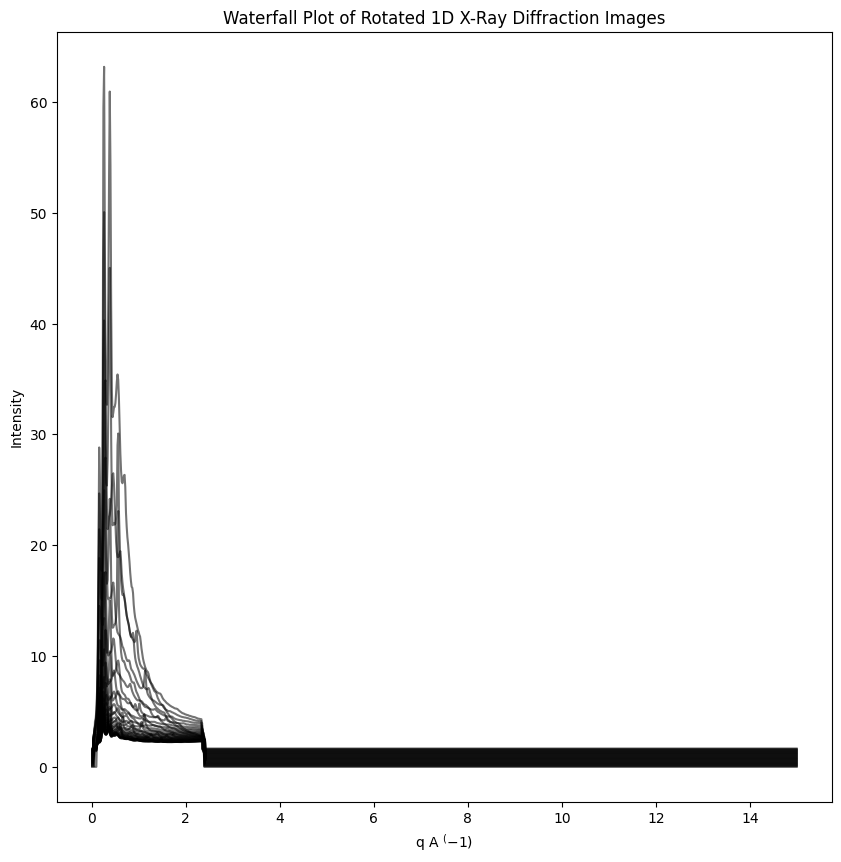

In [109]:
q, GST_6C_real_0035_nanmean_mask12 = rotate_and_integrate(gz_filled_with_mean, 5, .40008, 1.222e-10, resolution = 1000, mask = mask_12) 
# numpy turn NaN into mean of pixels next to it